# Opioid overdose deaths and ACS dataset merge and EDA

### Goals:

* Try normalizing death count data to town population (turn raw counts into deaths per 10k residents values) - evaluate if this improves the skew in the overdose death data
* Pull out some ACS demographics data - correlation with death counts/rate?
* EDA on ACS demographics data, some feature engineering on poverty, population, and other demographics data

### Output:
Opioid overdose death count (by town for years 2014-2018) merged with ACS demogrpahics data
* data/tidy_data/overdose_death_count_acs_merge.csv

pdf output in case notebook doesn't run:
* products/notebook_4_overdose_death_and_acs_by_census_block_merge_and_eda.pdf

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
death_data = pd.read_csv("../../data/tidy_data/ma_town_opioid_overdose_death_by_place_of_death_2014_to_2018.csv")
# from notebook 3 (town - census block matching)
town_block_match = pd.read_csv("../../data/tidy_data/census_block_town_match.csv")
town_w_2010pop = pd.read_csv("../../data/tidy_data/census_block_town_match_2010pop_error.csv")
# 2017 ACS dataset for MA state only, provided by Biobot
acs_17 = pd.read_csv("../../data/raw_data/american_community_survey/R12288202_SL150.csv")

In [3]:
death_data.head()

,city_death,2014,2015,2016,2017,2018
0,abington,0,6,1,3,5
1,acton,1,2,3,0,1
2,acushnet,0,4,2,4,0
3,adams,2,3,1,0,4
4,agawam,1,2,0,4,8


In [4]:
# town - census block match df:
display(town_block_match.head())
display(town_w_2010pop.head())

,TOWN,GEOID10
0,wellesley,2.502140e+11
1,wellesley,2.502140e+11
2,wellesley,2.502140e+11
3,wellesley,2.502140e+11
4,wellesley,2.502140e+11


,TOWN,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error
0,wellesley,27982,27982.0,0.0,0.000000
1,needham,28886,28886.0,0.0,0.000000
2,petersham,1234,1234.0,0.0,0.000000
3,reading,24747,24747.0,0.0,0.000000
4,quincy,92271,89703.0,-2568.0,2.783106


In [5]:
# town mismatch between death count data and the town-census block 
print(set(death_data['city_death']) - set(town_block_match['TOWN']))
print(set(town_block_match['TOWN']) - set(death_data['city_death']))
death_data['city_death'] = death_data['city_death'].str.replace('north attleboro', 'north attleborough')

{'north attleboro'}
{'north attleborough'}


In [6]:
# ACS size:
print(acs_17.shape)
# column name format:
acs_17.columns

(4985, 2200)


Index(['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US',
       ...
       'SE_A10065_001', 'SE_A10065_002', 'SE_A10066_001', 'SE_A10066_002',
       'SE_A10066_003', 'SE_A10066_004', 'SE_A10066_005', 'SE_A10066_006',
       'SE_A10066_007', 'SE_A10066_008'],
      dtype='object', length=2200)

In [7]:
# which columns to match on?
acs_17[['Geo_FIPS', 'Geo_GEOID']].head()
# Geo_FIPS is match for GEOID10 from town - block match df

,Geo_FIPS,Geo_GEOID
0,250010101001,15000US250010101001
1,250010101002,15000US250010101002
2,250010101003,15000US250010101003
3,250010101004,15000US250010101004
4,250010101005,15000US250010101005


In [8]:
# mismatches between sets?
print(len(set(acs_17['Geo_FIPS']) - set(town_block_match['GEOID10'])))
print(len(set(town_block_match['GEOID10']) - set(acs_17['Geo_FIPS'])))

31
4


### Potentially interesting columns to pull from ACS:
* A00002_001:   Total Population
* A00002_002:   Population Density (Per Sq. Mile)
* A12003_001:   Civilian Population 16 to 19 Years:
* A12003_002:      Not High School Graduate, Not Enrolled (Dropped Out)
* A12003_003:      High School Graduate, or Enrolled (In School)
* A12002_001:   Population 25 Years and Over:
* A12002_002:      Less than High School
* A14006_001:   Median Household Income (In 2017 Inflation Adjusted Dollars)
* A14008_001:   Average Household Income 
* NA- all missing - A14028_001:   Gini Index 
* NA - all missing - A17004_001:     Total Employed Civilian Population 16 Years and Over
* NA - all missing - A17004_002:     Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining
* NA - all missing - A17004_003:     Employed Civilian Population 16 Years and Over: Construction
* A01001_011:      65 to 74 Years
* A01001_012:      75 to 84 Years
* A01001_013:      85 Years and Over
* NA- all missing - A13003A_001:   Population Under 18 Years of Age for Whom Poverty Status Is Determined:
    * NA- all missing - A13003A_002:      Living in Poverty
    * NA- all missing - A13003A_003:      At or Above Poverty Level
* NA- all missing -A13003B_001:   Population Age 18 to 64 for Whom Poverty Status  Is Determined:
    * NA- all missing - A13003B_002:      Living in Poverty
    * NA- all missing - A13003B_003:      At or Above Poverty Level
* NA- all missing -A13003C_001:   Population Age 65 and Over for Whom Poverty  Status Is Determined:
    * NA- all missing -A13003C_002:      Living in Poverty
    * NA- all missing -A13003C_003:      At or Above Poverty Level
    
* B13004_001:     Population for Whom Poverty Status Is Determined:
    * B13004_002:     Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly)
    * B13004_003:     Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling)
    * B13004_004:     Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling)
    * B13004_005:     Population for Whom Poverty Status Is Determined: 2.00 and Over (Doing Ok)
* A13004_001:     Population for Whom Poverty Status Is Determined:    
    * A13004_002:     Population for Whom Poverty Status Is Determined: Under .50
    * NA- all missing - A13004_003:     Population for Whom Poverty Status Is Determined: .50 to .74
    * NA- all missing - A13004_004:     Population for Whom Poverty Status Is Determined: .75 to .99
    * A13004_005:     Population for Whom Poverty Status Is Determined: 1.00 to 1.49
    * A13004_006:     Population for Whom Poverty Status Is Determined: 1.50 to 1.99
    * A13004_007:     Population for Whom Poverty Status Is Determined: 2.00 and Over

In [9]:
acs_17_sub = acs_17[['Geo_FIPS', 'SE_A00002_001', 'SE_A00002_002',
     'SE_A12003_001', 'SE_A12003_002',
    'SE_A12002_001', 'SE_A12002_002', 'SE_A14006_001',
     'SE_A14008_001',
    # age 65+ cols:
     'SE_A01001_011', 'SE_A01001_012', 'SE_A01001_012',
    # poverty summarized:
    'SE_B13004_001', 'SE_B13004_002', 'SE_B13004_003', 'SE_B13004_004', 'SE_B13004_005'
    # poverty raw?:
    #'SE_A13004_001', 'SE_A13004_002', 'SE_A13004_003', 'SE_A13004_004', 'SE_A13004_005', 'SE_A13004_006', 'SE_A13004_007'
]].copy()

In [10]:
acs_17_sub.head()

,Geo_FIPS,SE_A00002_001,SE_A00002_002,SE_A12003_001,SE_A12003_002,SE_A12002_001,SE_A12002_002,SE_A14006_001,SE_A14008_001,SE_A01001_011,SE_A01001_012,SE_A01001_012,SE_B13004_001,SE_B13004_002,SE_B13004_003,SE_B13004_004,SE_B13004_005
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,172,51,51,998,122,271,393,605
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,107,43,43,314,55,36,91,223
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,133,82,82,741,59,81,140,601
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,46,78,78,500,46,206,252,248
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,62,15,15,390,32,59,91,299


In [11]:
# readable names:
acs_17_sub.columns = [
    'GEOID10', 'tot_pop_17', 'pop_density',
    'civ_pop_16_19', 'civ_pop_16_19_drop',
    'pop_over_25', 'pop_over_25_less_school',
    'med_house_inc', 'mean_house_inc',
    'age_65_to_74', 'age_75_to_84', 'age_85_over',
    'pop_det_poverty', 'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug', 'pop_doing_ok'
]

In [12]:
acs_17_sub.head()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,age_65_to_74,age_75_to_84,age_85_over,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,172,51,51,998,122,271,393,605
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,107,43,43,314,55,36,91,223
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,133,82,82,741,59,81,140,601
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,46,78,78,500,46,206,252,248
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,62,15,15,390,32,59,91,299


In [13]:
# calculate num and residents 
acs_17_sub['over_65_count'] = acs_17_sub['age_65_to_74'] + acs_17_sub['age_75_to_84'] + acs_17_sub['age_85_over']
acs_17_sub.drop(['age_65_to_74', 'age_75_to_84', 'age_85_over'], axis = 1, inplace=True)
acs_17_sub.head()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,over_65_count
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,998,122,271,393,605,274
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,314,55,36,91,223,193
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,741,59,81,140,601,297
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,500,46,206,252,248,202
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,390,32,59,91,299,92


In [14]:
acs_17_sub.describe()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,over_65_count
count,4.985000e+03,4985.000000,4978.000000,4985.000000,4985.000000,4985.000000,4985.000000,4754.000000,4945.000000,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000
mean,2.501713e+11,1361.949649,8442.368002,76.123170,2.065998,944.139619,91.891675,82522.340766,101843.077887,1314.412638,145.947041,165.163290,311.110331,1003.302307,240.608626
std,7.723758e+07,670.479216,12666.048861,137.109958,7.653031,455.980232,101.193132,40805.023166,52403.666245,642.014615,175.211379,157.779113,289.346330,588.097455,171.729713
min,2.500101e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2499.000000,14219.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500927e+11,880.000000,1082.917000,23.000000,0.000000,619.000000,23.000000,53333.000000,66678.928571,855.000000,34.000000,53.000000,109.000000,601.000000,121.000000
50%,2.501735e+11,1220.000000,3632.338000,51.000000,0.000000,851.000000,58.000000,77321.000000,92363.461538,1184.000000,85.000000,121.000000,225.000000,877.000000,206.000000
75%,2.502354e+11,1696.000000,10744.957500,91.000000,0.000000,1184.000000,128.000000,104048.250000,123559.710145,1650.000000,191.000000,227.000000,423.000000,1285.000000,319.000000
max,2.502776e+11,6760.000000,183026.000000,3499.000000,110.000000,3897.000000,783.000000,250001.000000,526877.386935,4882.000000,2259.000000,1392.000000,3260.000000,4279.000000,2178.000000


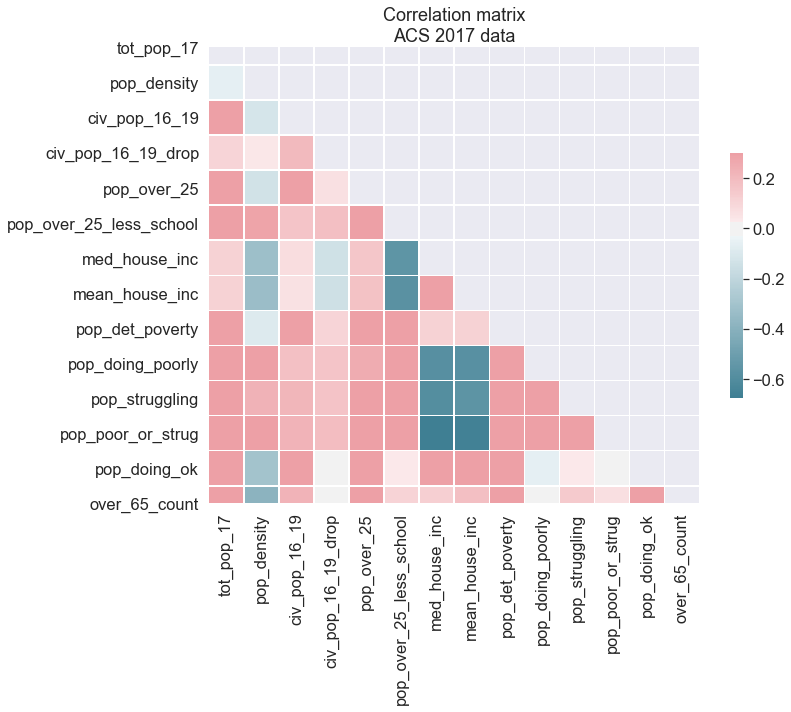

In [15]:
# code dapted from https://www.programcreek.com/python/example/96220/seaborn.diverging_palette
acs_sub_corr = acs_17_sub.drop('GEOID10', axis=1).corr(method='spearman')
mask = np.zeros_like(acs_sub_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(acs_sub_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix\nACS 2017 data')
plt.show()

Notes: 
* A lot of features are pretty correlated 
* poverty counts and mean/med income have strong correlations
* Will wait to do any kind of summarizing after the merge with town/census block df

In [16]:
print(acs_17_sub.columns)
print(town_block_match.columns)

Index(['GEOID10', 'tot_pop_17', 'pop_density', 'civ_pop_16_19',
       'civ_pop_16_19_drop', 'pop_over_25', 'pop_over_25_less_school',
       'med_house_inc', 'mean_house_inc', 'pop_det_poverty',
       'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug',
       'pop_doing_ok', 'over_65_count'],
      dtype='object')
Index(['TOWN', 'GEOID10'], dtype='object')


In [17]:
town_block = town_block_match.merge(town_w_2010pop, on='TOWN', how='inner')
print(town_block.shape)
print(len(set(town_block['TOWN'])))
print(len(set(town_block['GEOID10'])))
town_block.columns = ['city_death'] + list(town_block.columns)[1:]
# result:
town_block.head()

(4958, 6)
351
4958


,city_death,GEOID10,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error
0,wellesley,2.502140e+11,27982,27982.0,0.0,0.0
1,wellesley,2.502140e+11,27982,27982.0,0.0,0.0
2,wellesley,2.502140e+11,27982,27982.0,0.0,0.0
3,wellesley,2.502140e+11,27982,27982.0,0.0,0.0
4,wellesley,2.502140e+11,27982,27982.0,0.0,0.0


In [18]:
town_acs_merge = town_block.merge(acs_17_sub, on='GEOID10', how='inner')
print(town_acs_merge.shape)
print(town_acs_merge.columns)
town_acs_merge.head()

(4954, 20)
Index(['city_death', 'GEOID10', 'town_actual_2010_pop', 'block_est_2010_pop',
       'count_error', 'percent_error', 'tot_pop_17', 'pop_density',
       'civ_pop_16_19', 'civ_pop_16_19_drop', 'pop_over_25',
       'pop_over_25_less_school', 'med_house_inc', 'mean_house_inc',
       'pop_det_poverty', 'pop_doing_poorly', 'pop_struggling',
       'pop_poor_or_strug', 'pop_doing_ok', 'over_65_count'],
      dtype='object')


,city_death,GEOID10,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,over_65_count
0,wellesley,2.502140e+11,27982,27982.0,0.0,0.0,1101,4438.051,96,0,636,0,183879.0,214803.395062,1101,0,0,0,1101,137
1,wellesley,2.502140e+11,27982,27982.0,0.0,0.0,924,2064.697,108,0,634,0,250001.0,505804.304636,924,0,0,0,924,197
2,wellesley,2.502140e+11,27982,27982.0,0.0,0.0,881,1947.536,9,0,552,11,181786.0,244652.447552,875,12,9,21,854,231
3,wellesley,2.502140e+11,27982,27982.0,0.0,0.0,1177,2961.899,38,0,685,30,129071.0,240321.641791,1177,144,100,244,933,105
4,wellesley,2.502140e+11,27982,27982.0,0.0,0.0,767,3843.039,10,0,590,22,86827.0,145115.151515,767,64,95,159,608,275


To summarize, some columns need to be added by town (count columns) and some need to be averaged

First, columns that will be added up by group:

In [19]:
sum_stat_cols = [
    'city_death', 'tot_pop_17', 'over_65_count',
    'civ_pop_16_19', 'civ_pop_16_19_drop',
    'pop_over_25', 'pop_over_25_less_school',
    'pop_det_poverty', 'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug', 'pop_doing_ok'
]
town_17_pop = town_acs_merge.groupby('city_death').sum().reset_index()[sum_stat_cols]
town_17_pop.head()

,city_death,tot_pop_17,over_65_count,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok
0,abington,16275,2469,753,26,11377,615,16194,579,1626,2205,13989
1,acton,23455,4001,1476,18,16161,397,23307,893,973,1866,21441
2,acushnet,10443,2431,564,62,7635,1397,10336,422,1844,2266,8070
3,adams,8211,1764,333,23,6095,723,8209,910,1187,2097,6112
4,agawam,27769,6195,1177,0,20674,1602,26925,2553,3841,6394,20531


Columns that will be averaged by group:
Note: for 2010 actual and estimated error columns, as well as the count and percent error - this will return the values from the original imported df

In [20]:
mean_stat_cols = ['city_death', 'town_actual_2010_pop', 'block_est_2010_pop', 
                  'count_error', 'percent_error', 'pop_density',
                  'med_house_inc', 'mean_house_inc']
town_stats = town_acs_merge.groupby('city_death').mean().reset_index()[mean_stat_cols]
town_stats.head()

,city_death,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc
0,abington,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505
1,acton,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867
2,acushnet,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842
3,adams,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660
4,agawam,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446


In [21]:
town_merge = town_17_pop.merge(town_stats, on='city_death', how='inner')
print(town_merge.shape)
town_merge.head()

(347, 19)


,city_death,tot_pop_17,over_65_count,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc
0,abington,16275,2469,753,26,11377,615,16194,579,1626,2205,13989,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505
1,acton,23455,4001,1476,18,16161,397,23307,893,973,1866,21441,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867
2,acushnet,10443,2431,564,62,7635,1397,10336,422,1844,2266,8070,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842
3,adams,8211,1764,333,23,6095,723,8209,910,1187,2097,6112,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660
4,agawam,27769,6195,1177,0,20674,1602,26925,2553,3841,6394,20531,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446


Some summary stats: 
* drop out rate among 16-19 year olds
* estimate of proportion of population that's over 25 with less than a high school education

In [22]:
town_merge['drop_out'] = (town_merge['civ_pop_16_19_drop'] * 100) / town_merge['civ_pop_16_19']
town_merge['less_than_hs_ed'] = (town_merge['pop_over_25_less_school'] * 100) / town_merge['pop_over_25']
town_merge.drop(['pop_over_25', 'pop_over_25_less_school', 'civ_pop_16_19_drop', 'civ_pop_16_19'], axis = 1, inplace=True)
town_merge.head()

,city_death,tot_pop_17,over_65_count,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,drop_out,less_than_hs_ed
0,abington,16275,2469,16194,579,1626,2205,13989,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505,3.452855,5.405643
1,acton,23455,4001,23307,893,973,1866,21441,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867,1.219512,2.456531
2,acushnet,10443,2431,10336,422,1844,2266,8070,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842,10.992908,18.297315
3,adams,8211,1764,8209,910,1187,2097,6112,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660,6.906907,11.862182
4,agawam,27769,6195,26925,2553,3841,6394,20531,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446,0.000000,7.748863


In [23]:
# before calculated dropout by block - had many zeroes - is this alterntive method more informative?
town_merge[['drop_out', 'less_than_hs_ed']].describe()

,drop_out,less_than_hs_ed
count,346.000000,347.000000
mean,2.355802,6.544580
std,4.012968,4.750990
min,0.000000,0.000000
25%,0.000000,3.235427
50%,0.318954,5.405643
75%,3.184586,8.318470
max,30.000000,32.336132


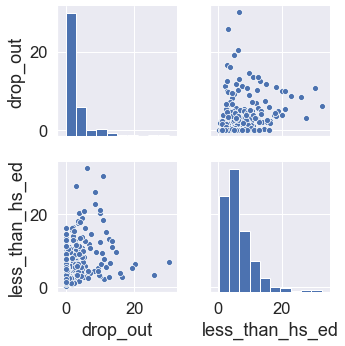

In [24]:
# what's the distribution of these 2 new variables and what is the relationship between them?
sns.pairplot(town_merge[['drop_out', 'less_than_hs_ed']].dropna())
plt.show()

New dropout variable has a lot of zeroes - probably not useful - drop it

In [25]:
town_merge.drop('drop_out', axis=1, inplace=True)
town_merge.head()

,city_death,tot_pop_17,over_65_count,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed
0,abington,16275,2469,16194,579,1626,2205,13989,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505,5.405643
1,acton,23455,4001,23307,893,973,1866,21441,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867,2.456531
2,acushnet,10443,2431,10336,422,1844,2266,8070,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842,18.297315
3,adams,8211,1764,8209,910,1187,2097,6112,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660,11.862182
4,agawam,27769,6195,26925,2553,3841,6394,20531,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446,7.748863


Maybe the proportion of people over 65 in a town could be useful?

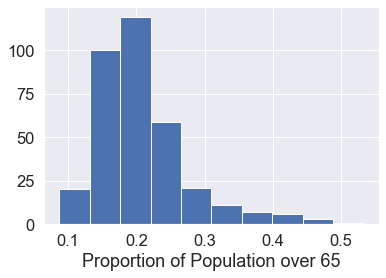

In [26]:
town_merge['over_65_prop'] = town_merge['over_65_count'] / town_merge['tot_pop_17']
town_merge['over_65_prop'].hist()
plt.xlabel('Proportion of Population over 65')
plt.show()

The different columns relating to poverty need to be summarized in some way.

What the different rations of income/poverty mean:
* Doing Poorly: Under 1.00
* Struggling: 1.00 to 1.99
* Poor or Struggling: Under 2.00
* Doing OK: 2.00 and Over

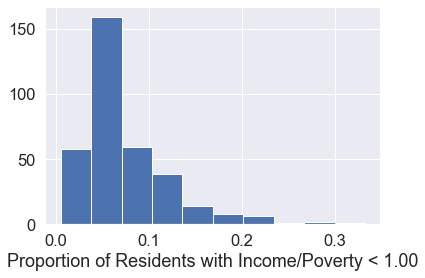

In [27]:
# poverty calc
town_merge.head()
town_merge['at_or_below_pov_prop'] = town_merge['pop_doing_poorly'] / town_merge['pop_det_poverty']
town_merge['at_or_below_pov_prop'].hist(bins=10)
plt.xlabel('Proportion of Residents with Income/Poverty < 1.00')
plt.show()

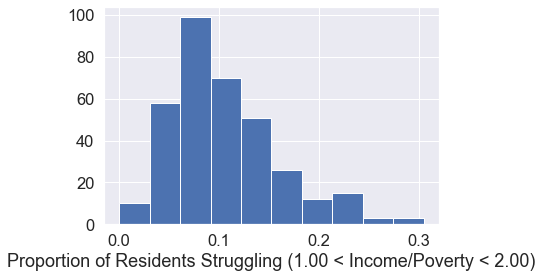

In [28]:
town_merge['pop_struggling_prop'] = town_merge['pop_struggling'] / town_merge['pop_det_poverty']
town_merge['pop_struggling_prop'].hist(bins=10)
plt.xlabel('Proportion of Residents Struggling (1.00 < Income/Poverty < 2.00)')
plt.show()

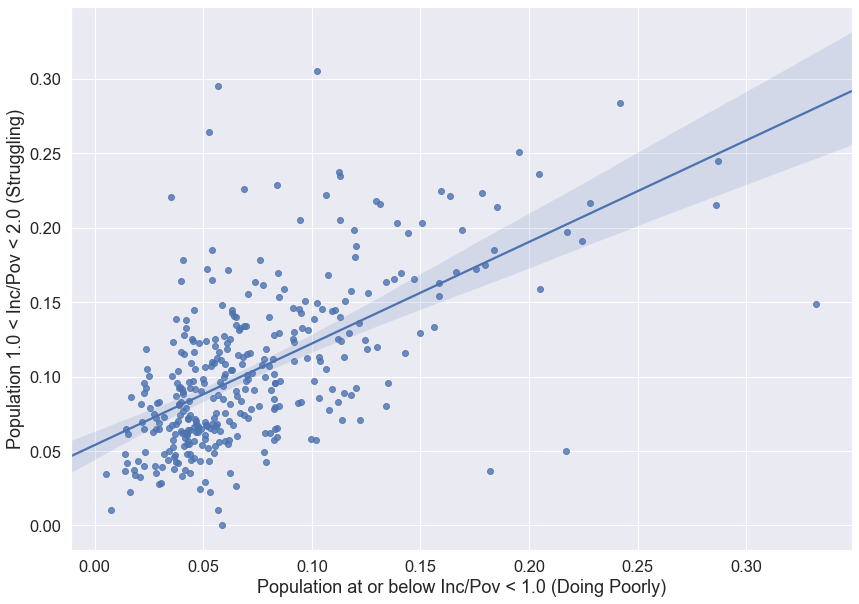

In [29]:
# what's the relationship between these 2?
plt.figure(figsize=(14,10))
sns.regplot(x='at_or_below_pov_prop', y='pop_struggling_prop', data=town_merge)
plt.xlabel('Population at or below Inc/Pov < 1.0 (Doing Poorly)')
plt.ylabel('Population 1.0 < Inc/Pov < 2.0 (Struggling)')
plt.show()

In [30]:
# drop count data
town_merge.drop(['pop_det_poverty', 'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug', 'pop_doing_ok'], axis=1, inplace=True)
town_merge.head()

,city_death,tot_pop_17,over_65_count,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop
0,abington,16275,2469,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505,5.405643,0.151705,0.035754,0.100408
1,acton,23455,4001,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867,2.456531,0.170582,0.038315,0.041747
2,acushnet,10443,2431,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842,18.297315,0.232788,0.040828,0.178406
3,adams,8211,1764,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660,11.862182,0.214834,0.110854,0.144597
4,agawam,27769,6195,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446,7.748863,0.223090,0.094819,0.142656


In [31]:
# distributions of current
town_merge.describe()

,tot_pop_17,over_65_count,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,346.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,19490.746398,3434.824207,18858.389049,18794.827089,-63.561960,5.979779,2292.685930,88305.727278,109444.035932,6.544580,0.207933,0.073728,0.104279
std,41540.511381,5642.967441,39009.479522,38920.193487,445.473371,44.749992,4049.633320,29088.836206,39888.981321,4.750990,0.068754,0.047828,0.054009
min,34.000000,15.000000,75.000000,75.000000,-3861.000000,0.000000,2.578370,38909.750000,50750.537570,0.000000,0.086886,0.005354,0.000000
25%,4196.000000,781.000000,4008.000000,4008.000000,0.000000,0.000000,285.202885,68215.428571,82839.316239,3.235427,0.166202,0.042404,0.064869
50%,10560.000000,1977.000000,10300.000000,10209.000000,0.000000,0.000000,933.183133,83124.625000,100209.367399,5.405643,0.193279,0.059730,0.092496
75%,22704.000000,4385.000000,21691.500000,21691.500000,0.000000,0.000000,2452.889962,102446.289216,126078.167762,8.318470,0.230995,0.092880,0.132362
max,668541.000000,85040.000000,617594.000000,616852.000000,1323.000000,733.532934,30236.970333,203026.750000,316351.858774,32.336132,0.532847,0.332260,0.304869


In [32]:
print(set(death_data['city_death']) - set(town_merge['city_death']))
print(set(town_merge['city_death']) - set(death_data['city_death']))

{'monroe', 'egremont', 'charlemont', 'worthington'}
set()


In [33]:
# combine town info + opioid overdose death count data
full_merge = town_merge.merge(death_data, on='city_death', how='inner')
print(full_merge.shape)
full_merge.head()

(347, 19)


,city_death,tot_pop_17,over_65_count,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop,2014,2015,2016,2017,2018
0,abington,16275,2469,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505,5.405643,0.151705,0.035754,0.100408,0,6,1,3,5
1,acton,23455,4001,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867,2.456531,0.170582,0.038315,0.041747,1,2,3,0,1
2,acushnet,10443,2431,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842,18.297315,0.232788,0.040828,0.178406,0,4,2,4,0
3,adams,8211,1764,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660,11.862182,0.214834,0.110854,0.144597,2,3,1,0,4
4,agawam,27769,6195,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446,7.748863,0.223090,0.094819,0.142656,1,2,0,4,8


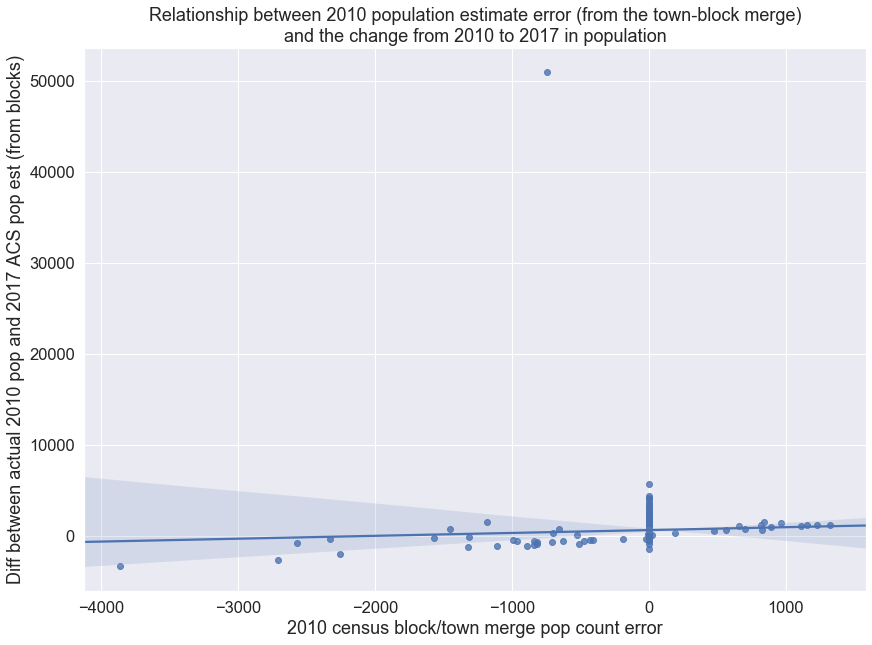

In [34]:
full_merge['pop_change_10_to_17'] = full_merge['tot_pop_17'] - full_merge['town_actual_2010_pop']
plt.figure(figsize=(14,10))
sns.regplot(x='count_error', y='pop_change_10_to_17', data=full_merge)
plt.xlabel('2010 census block/town merge pop count error')
plt.ylabel('Diff between actual 2010 pop and 2017 ACS pop est (from blocks)')
plt.title('Relationship between 2010 population estimate error (from the town-block merge)\nand the change from 2010 to 2017 in population')
plt.show()

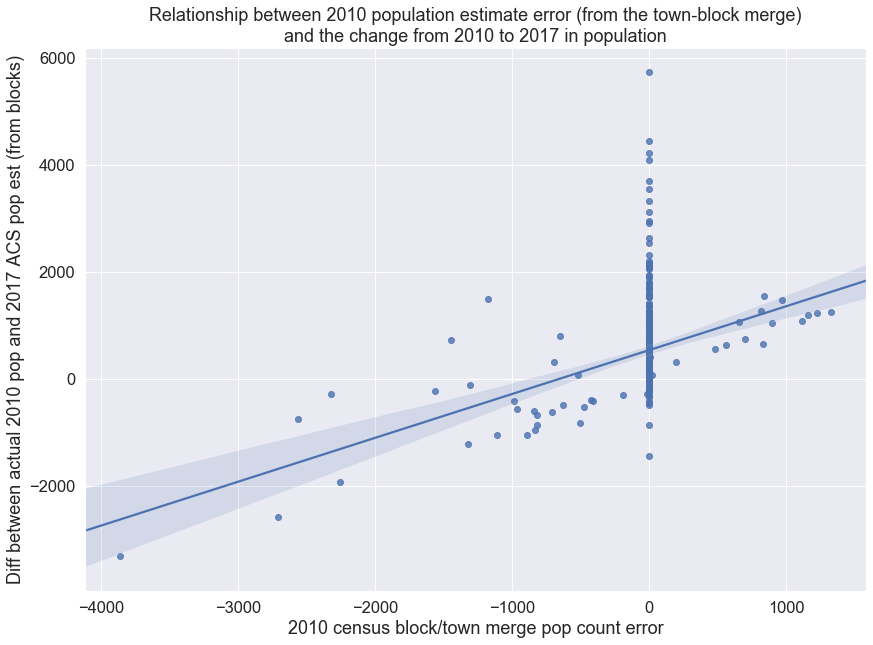

In [35]:
# take out the one big change point (Boston)
plt.figure(figsize=(14,10))
sns.regplot(x='count_error', y='pop_change_10_to_17',
            data=full_merge[full_merge['pop_change_10_to_17'] < 40000])
plt.xlabel('2010 census block/town merge pop count error')
plt.ylabel('Diff between actual 2010 pop and 2017 ACS pop est (from blocks)')
plt.title('Relationship between 2010 population estimate error (from the town-block merge)\nand the change from 2010 to 2017 in population')
plt.show()

Notes:
* There does seem to be some relationship between the error in the 2010 estimation and the difference between the 2017 population estimate (also derived from census block data) and the 2010 actual count - makes sense
* But it's not perfectly 1-to-1 - the difference between (2017 estimate - 2010 actual) and (2010 estimate - 2010 actual) seems to be smaller

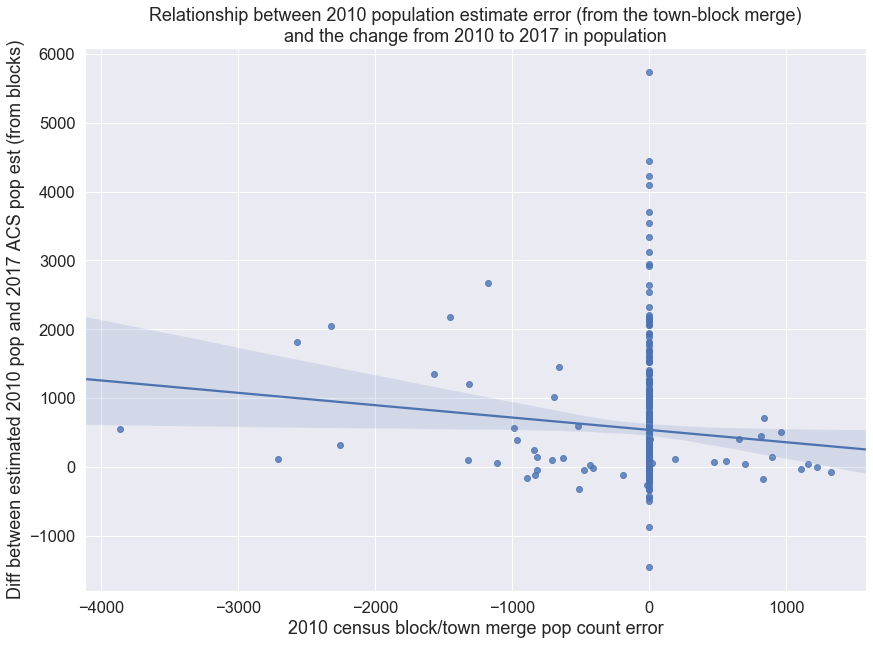

In [36]:
full_merge['pop_change_10_to_17_est'] = full_merge['tot_pop_17'] - full_merge['block_est_2010_pop']
plt.figure(figsize=(14,10))
sns.regplot(x='count_error', y='pop_change_10_to_17_est',
            data=full_merge[full_merge['pop_change_10_to_17_est'] < 40000])
plt.xlabel('2010 census block/town merge pop count error')
plt.ylabel('Diff between estimated 2010 pop and 2017 ACS pop est (from blocks)')
plt.title('Relationship between 2010 population estimate error (from the town-block merge)\nand the change from 2010 to 2017 in population')
plt.show()

In [37]:
print(sum(full_merge['pop_change_10_to_17_est'] == 0))
print(sum(full_merge['pop_change_10_to_17'] == 0))

0
0


Will use 2010 estimate derived from the town - census block merge vs 2017 estimate derived from merge to estimate growth rate (hopefully the error made from census blocks-town assignment means a similar error for both estimates)

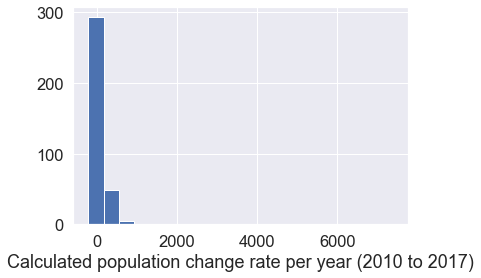

In [38]:
full_merge['pop_change_rate'] = full_merge['pop_change_10_to_17_est'] / (2017 - 2010)
full_merge['pop_change_rate'].hist(bins=20)
plt.xlabel('Calculated population change rate per year (2010 to 2017)')
plt.show()

In [39]:
full_merge[full_merge['pop_change_rate'] > 1000]

,city_death,tot_pop_17,over_65_count,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,...,at_or_below_pov_prop,pop_struggling_prop,2014,2015,2016,2017,2018,pop_change_10_to_17,pop_change_10_to_17_est,pop_change_rate
35,boston,668541,85040,617594.0,616852.0,-742.0,0.120144,27786.891612,71196.049505,92167.940523,...,0.205154,0.158644,167,226,259,279,245,50947.0,51689.0,7384.142857


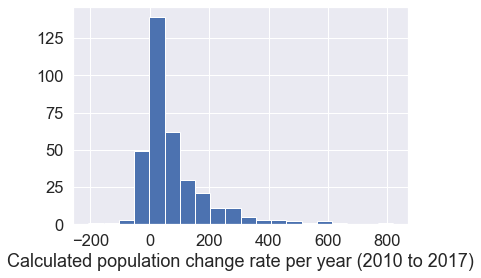

In [40]:
# remove extreme point (Boston)
full_merge[full_merge['pop_change_rate'] < 1000]['pop_change_rate'].hist(bins=20)
plt.xlabel('Calculated population change rate per year (2010 to 2017)')
plt.show()

In [41]:
full_merge[(full_merge['pop_change_rate'] > -10) & (full_merge['pop_change_rate'] < 10)]

,city_death,tot_pop_17,over_65_count,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,...,at_or_below_pov_prop,pop_struggling_prop,2014,2015,2016,2017,2018,pop_change_10_to_17,pop_change_10_to_17_est,pop_change_rate
29,bernardston,1074,261,2129.0,1018.0,-1111.0,52.184124,86.640560,70500.000000,82633.333333,...,0.035382,0.220670,0,0,0,0,0,-1055.0,56.0,8.000000
33,blandford,1259,306,1233.0,1233.0,0.0,0.000000,24.411060,62875.000000,78223.844732,...,0.070691,0.155679,0,0,0,0,0,26.0,26.0,3.714286
36,bourne,19832,4614,19754.0,19776.0,22.0,0.111370,1009.739420,69166.937500,91659.357901,...,0.068506,0.112949,2,4,6,1,4,78.0,56.0,8.000000
41,brewster,9856,3274,9820.0,9820.0,0.0,0.000000,491.873789,71159.111111,93807.274446,...,0.048019,0.122623,0,1,1,1,0,36.0,36.0,5.142857
45,brookfield,3406,791,3390.0,3390.0,0.0,0.000000,237.359100,63971.333333,86589.528959,...,0.091930,0.110553,0,0,0,2,1,16.0,16.0,2.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,warren,5199,554,5135.0,5135.0,0.0,0.000000,279.391975,68332.000000,70051.858136,...,0.112906,0.205424,1,0,0,0,1,64.0,64.0,9.142857
309,washington,499,158,538.0,538.0,0.0,0.000000,13.137440,86389.000000,91221.120690,...,0.028169,0.072435,0,0,0,0,0,-39.0,-39.0,-5.571429
315,wendell,864,204,848.0,848.0,0.0,0.000000,27.134650,42750.000000,65966.497462,...,0.175581,0.172093,0,0,0,0,0,16.0,16.0,2.285714
336,williamsburg,2481,578,2482.0,2482.0,0.0,0.000000,119.907030,74244.500000,95587.601080,...,0.108021,0.077791,0,0,0,0,1,-1.0,-1.0,-0.142857


In [42]:
# number of towns with negative growth rate
full_merge[full_merge['pop_change_rate'] < 0].shape

(60, 22)

* Tried to pull in more years of ACS data, but it was challenging to find and extract the data
* Will use rough estimates to guess population changes

In [43]:
# rough estimates of yearly population
full_merge['tot_pop_16'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate']
full_merge['tot_pop_15'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 2
full_merge['tot_pop_14'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 3
full_merge['tot_pop_13'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 4
full_merge.head()

,city_death,tot_pop_17,over_65_count,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,...,2016,2017,2018,pop_change_10_to_17,pop_change_10_to_17_est,pop_change_rate,tot_pop_16,tot_pop_15,tot_pop_14,tot_pop_13
0,abington,16275,2469,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505,...,1,3,5,290.0,290.0,41.428571,16233.571429,16192.142857,16150.714286,16109.285714
1,acton,23455,4001,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867,...,3,0,1,1531.0,1531.0,218.714286,23236.285714,23017.571429,22798.857143,22580.142857
2,acushnet,10443,2431,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842,...,2,4,0,140.0,140.0,20.000000,10423.000000,10403.000000,10383.000000,10363.000000
3,adams,8211,1764,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660,...,1,0,4,-274.0,-274.0,-39.142857,8250.142857,8289.285714,8328.428571,8367.571429
4,agawam,27769,6195,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446,...,0,4,8,-669.0,148.0,21.142857,27747.857143,27726.714286,27705.571429,27684.428571


In [44]:
# classify a town as shrining or growing based on the rate of population change
full_merge['town_status'] = ['grown' if x > 10 else 'shrunk' if x < -10 else 'uncertain' for x in full_merge['pop_change_rate']]
full_merge['town_status'].value_counts()

grown        252
uncertain     62
shrunk        33
Name: town_status, dtype: int64

In [45]:
# simple definition of urban vs rural
full_merge['urb_v_rur'] = ['urban' if x >= 50000 else 'rural' for x in full_merge['tot_pop_17']]
full_merge['urb_v_rur'].value_counts()

rural    322
urban     25
Name: urb_v_rur, dtype: int64

I want to experiment with converting the death count to a death rate by normalizing it to the population estimate

* will it change the distribution? (the count data is very skewed)
* what is the relationship between the death rate and some of the other variables pulled out from the 2017 ACS?

In [46]:
# calculate opioid overdose death rate per 10k residents (so that numbers aren't just small decimals)
rate_exp = full_merge.copy()
rate_exp['death_rate_17'] = (rate_exp['2017'] / rate_exp['tot_pop_17']) * 10000
rate_exp.head()

,city_death,tot_pop_17,over_65_count,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error,pop_density,med_house_inc,mean_house_inc,...,pop_change_10_to_17,pop_change_10_to_17_est,pop_change_rate,tot_pop_16,tot_pop_15,tot_pop_14,tot_pop_13,town_status,urb_v_rur,death_rate_17
0,abington,16275,2469,15985.0,15985.0,0.0,0.000000,1932.969130,87156.000000,98809.035505,...,290.0,290.0,41.428571,16233.571429,16192.142857,16150.714286,16109.285714,grown,rural,1.843318
1,acton,23455,4001,21924.0,21924.0,0.0,0.000000,1257.583593,139890.466667,156680.203867,...,1531.0,1531.0,218.714286,23236.285714,23017.571429,22798.857143,22580.142857,grown,rural,0.000000
2,acushnet,10443,2431,10303.0,10303.0,0.0,0.000000,1152.357871,69624.714286,80333.175842,...,140.0,140.0,20.000000,10423.000000,10403.000000,10383.000000,10363.000000,grown,rural,3.830317
3,adams,8211,1764,8485.0,8485.0,0.0,0.000000,1982.318840,48445.400000,60968.594660,...,-274.0,-274.0,-39.142857,8250.142857,8289.285714,8328.428571,8367.571429,shrunk,rural,0.000000
4,agawam,27769,6195,28438.0,27621.0,-817.0,2.872917,1897.273569,65490.125000,79464.234446,...,-669.0,148.0,21.142857,27747.857143,27726.714286,27705.571429,27684.428571,grown,rural,1.440455


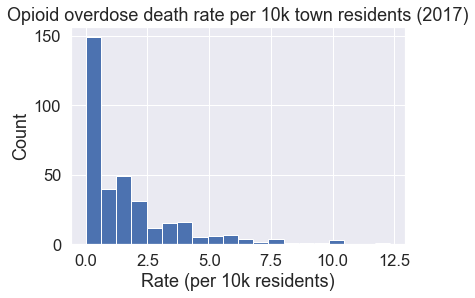

In [47]:
rate_exp['death_rate_17'].hist(bins=20)
plt.xlabel('Rate (per 10k residents)')
plt.ylabel('Count')
plt.title('Opioid overdose death rate per 10k town residents (2017)')
plt.show()

In [48]:
rate_exp.columns

Index(['city_death', 'tot_pop_17', 'over_65_count', 'town_actual_2010_pop',
       'block_est_2010_pop', 'count_error', 'percent_error', 'pop_density',
       'med_house_inc', 'mean_house_inc', 'less_than_hs_ed', 'over_65_prop',
       'at_or_below_pov_prop', 'pop_struggling_prop', '2014', '2015', '2016',
       '2017', '2018', 'pop_change_10_to_17', 'pop_change_10_to_17_est',
       'pop_change_rate', 'tot_pop_16', 'tot_pop_15', 'tot_pop_14',
       'tot_pop_13', 'town_status', 'urb_v_rur', 'death_rate_17'],
      dtype='object')

In [49]:
rate_exp_columns = list(rate_exp.columns)
rate_exp_col_sub = rate_exp_columns[0:1] + rate_exp_columns[7:14] + rate_exp_columns[21:22] + rate_exp_columns[26:]
rate_exp_sub = rate_exp[rate_exp_col_sub].copy()
rate_exp_sub.head()

,city_death,pop_density,med_house_inc,mean_house_inc,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop,pop_change_rate,town_status,urb_v_rur,death_rate_17
0,abington,1932.969130,87156.000000,98809.035505,5.405643,0.151705,0.035754,0.100408,41.428571,grown,rural,1.843318
1,acton,1257.583593,139890.466667,156680.203867,2.456531,0.170582,0.038315,0.041747,218.714286,grown,rural,0.000000
2,acushnet,1152.357871,69624.714286,80333.175842,18.297315,0.232788,0.040828,0.178406,20.000000,grown,rural,3.830317
3,adams,1982.318840,48445.400000,60968.594660,11.862182,0.214834,0.110854,0.144597,-39.142857,shrunk,rural,0.000000
4,agawam,1897.273569,65490.125000,79464.234446,7.748863,0.223090,0.094819,0.142656,21.142857,grown,rural,1.440455


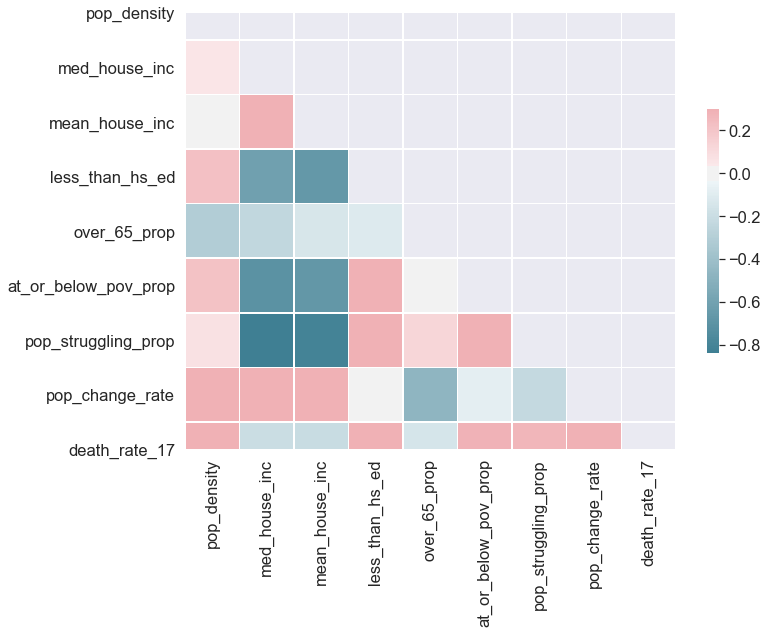

In [50]:
rate_exp_sub_corr = rate_exp_sub.drop(['city_death', 'town_status', 'urb_v_rur'], axis=1).dropna().corr(method='spearman')
mask = np.zeros_like(rate_exp_sub_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(rate_exp_sub_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [51]:
rate_exp_sub_corr.sort_values('death_rate_17', ascending=False)['death_rate_17']

death_rate_17           1.000000
pop_density             0.577145
pop_change_rate         0.375721
less_than_hs_ed         0.353322
at_or_below_pov_prop    0.290039
pop_struggling_prop     0.270851
over_65_prop           -0.145125
med_house_inc          -0.198810
mean_house_inc         -0.204348
Name: death_rate_17, dtype: float64

Looks like there are some weak positive and negative correlations
* pop_density correlation surprisingly high - think it has to do with urban/rural (city vs urban)

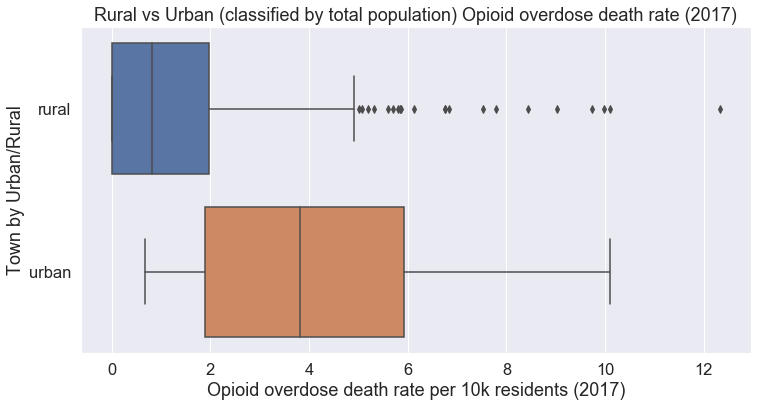

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='urb_v_rur', x='death_rate_17', orient='h', data=rate_exp_sub)
plt.ylabel('Town by Urban/Rural')
plt.xlabel('Opioid overdose death rate per 10k residents (2017)')
plt.title('Rural vs Urban (classified by total population) Opioid overdose death rate (2017)')
plt.show()

In [53]:
# mean overdose death rate for 2017
print(round(rate_exp_sub['death_rate_17'].mean(), 2))
# standard error of the mean (sem) the rate:
print(round(rate_exp_sub[['death_rate_17']].sem(axis=0), 2))
rate_exp_sub[['urb_v_rur', 'death_rate_17']].groupby('urb_v_rur').mean()

1.63
death_rate_17    0.12
dtype: float64


,death_rate_17
urb_v_rur,
rural,1.441318
urban,4.020464


"Urban" (high population area) rate seems to be much higher than low population areas

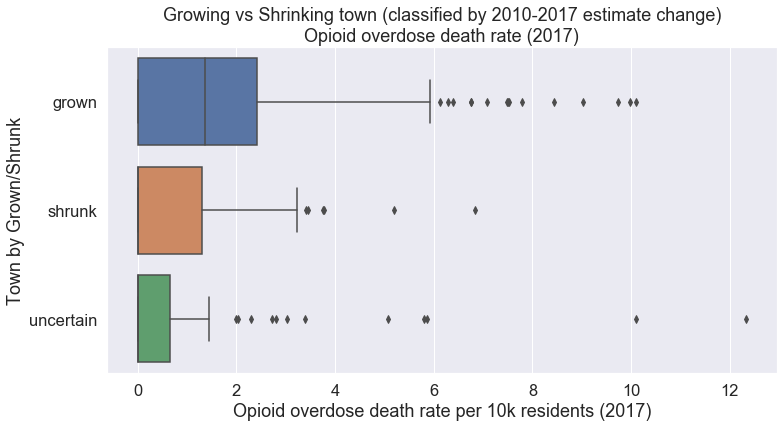

In [54]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='town_status', x='death_rate_17', orient='h', data=rate_exp_sub)
plt.ylabel('Town by Grown/Shrunk')
plt.xlabel('Opioid overdose death rate per 10k residents (2017)')
plt.title('Growing vs Shrinking town (classified by 2010-2017 estimate change)\nOpioid overdose death rate (2017)')
plt.show()

In [55]:
rate_exp_sub[['town_status', 'death_rate_17']].groupby('town_status').mean()

,death_rate_17
town_status,
grown,1.858204
shrunk,1.029335
uncertain,1.006140


Small difference with large errors/outliers? - may not be meaningful

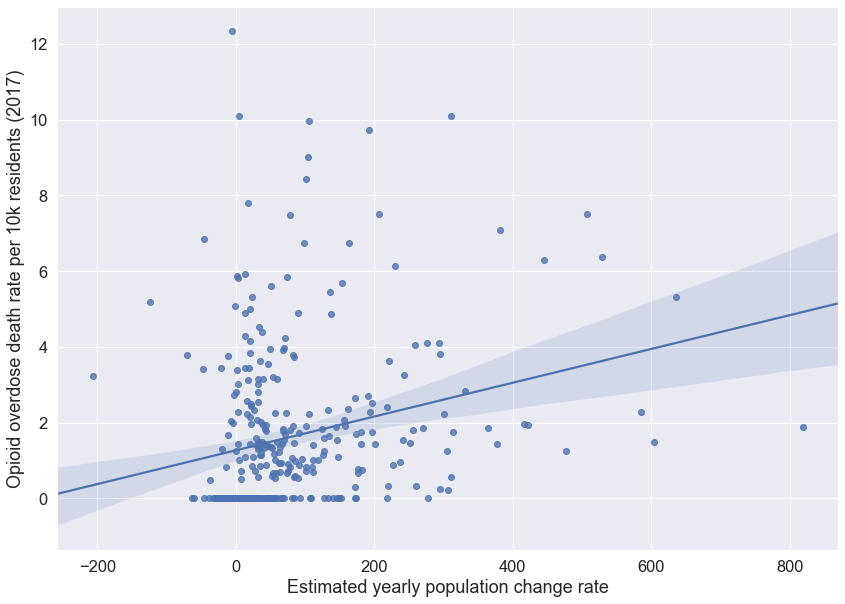

In [56]:
plt.figure(figsize=(14, 10))
sns.regplot(x='pop_change_rate', y='death_rate_17', data=rate_exp_sub[rate_exp_sub['pop_change_rate'] < 1000])
plt.xlabel('Estimated yearly population change rate')
plt.ylabel('Opioid overdose death rate per 10k residents (2017)')
plt.show()

Think the estimated population change will probably not be useful, also most likely these two variables are confounded because population estimates for each year were calculated using the population change rate.

Population density probably related to the urban/rural difference seen earlier - what's the relationship of this variable to the death rate?

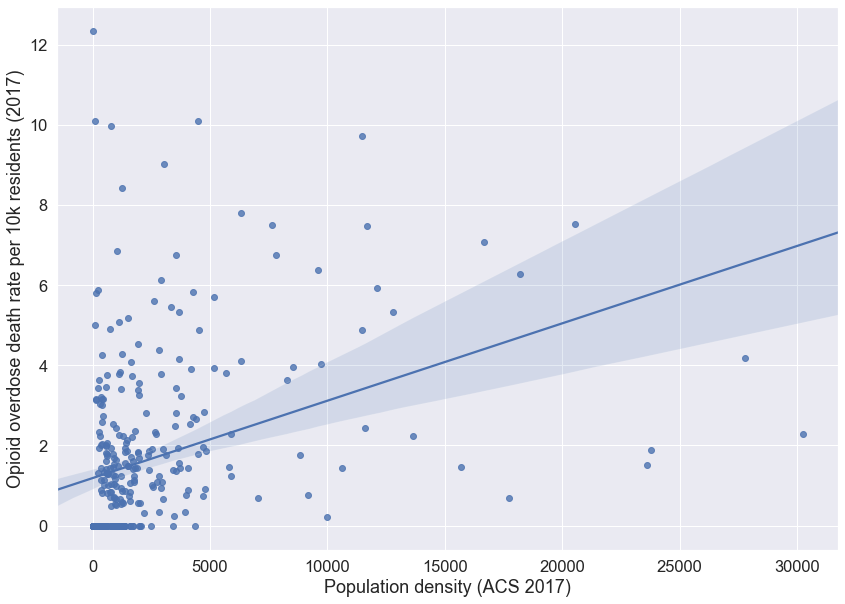

In [57]:
plt.figure(figsize=(14, 10))
sns.regplot(x='pop_density', y='death_rate_17', data=rate_exp_sub)
plt.xlabel('Population density (ACS 2017)')
plt.ylabel('Opioid overdose death rate per 10k residents (2017)')
plt.show()

Data too noisy to tell if there is a true relationship - this is probably not a useful metric, but what if I try to take the square root of the density (maybe it's too skewed?)

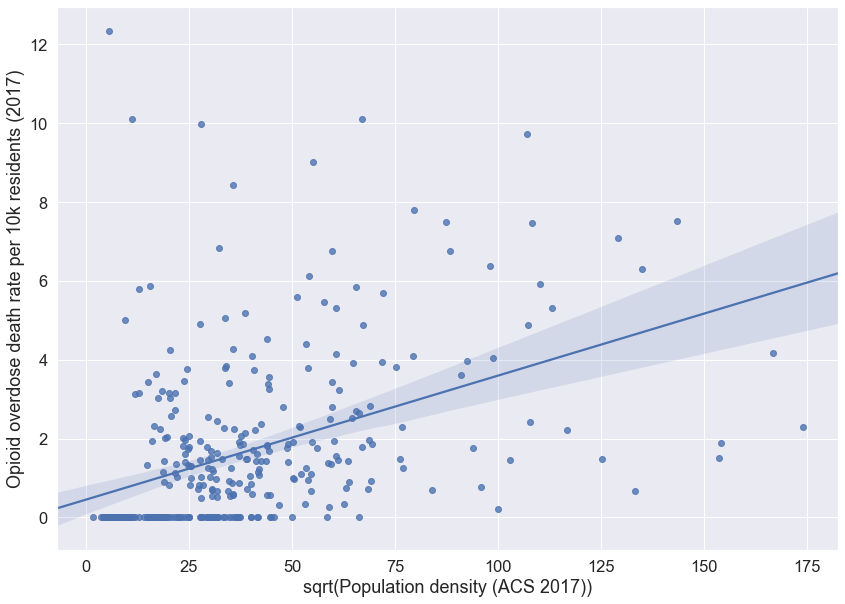

In [58]:
rate_exp_sub['pop_den_sqrt'] = np.sqrt(rate_exp_sub['pop_density'])
plt.figure(figsize=(14, 10))
sns.regplot(x='pop_den_sqrt', y='death_rate_17', data=rate_exp_sub)
plt.xlabel('sqrt(Population density (ACS 2017))')
plt.ylabel('Opioid overdose death rate per 10k residents (2017)')
plt.show()

There might be a positive relationship - but still a lot of noise

## Prep for export

Note: I had originally planned to predict/model the death rates instead of the raw counts - but that didn't go well and I switched focus to trying to model the counts instead (but included the total population estimates in the model as a way to account for differences in counts based on population)

In [59]:
full_merge.columns

Index(['city_death', 'tot_pop_17', 'over_65_count', 'town_actual_2010_pop',
       'block_est_2010_pop', 'count_error', 'percent_error', 'pop_density',
       'med_house_inc', 'mean_house_inc', 'less_than_hs_ed', 'over_65_prop',
       'at_or_below_pov_prop', 'pop_struggling_prop', '2014', '2015', '2016',
       '2017', '2018', 'pop_change_10_to_17', 'pop_change_10_to_17_est',
       'pop_change_rate', 'tot_pop_16', 'tot_pop_15', 'tot_pop_14',
       'tot_pop_13', 'town_status', 'urb_v_rur'],
      dtype='object')

In [94]:
full_merge_cols = list(full_merge.columns)
full_merge_select = full_merge_cols[0:3] + full_merge_cols[8:19] + full_merge_cols[22:]
print(full_merge_select)
print(len(full_merge_select))
print(len(set(full_merge_select)))
full_merge_reorder = full_merge_select[:1] + full_merge_select[9:14] + full_merge_select[17:13:-1] + full_merge_select[1:2] + full_merge_select[2:3] + full_merge_select[6:7] + full_merge_select[3:6] + full_merge_select[7:9] + full_merge_select[-1:-3:-1]
print(full_merge_reorder)
print(len(full_merge_reorder))
# make sure no columns were doubl copied
print(len(set(full_merge_reorder)))

['city_death', 'tot_pop_17', 'over_65_count', 'med_house_inc', 'mean_house_inc', 'less_than_hs_ed', 'over_65_prop', 'at_or_below_pov_prop', 'pop_struggling_prop', '2014', '2015', '2016', '2017', '2018', 'tot_pop_16', 'tot_pop_15', 'tot_pop_14', 'tot_pop_13', 'town_status', 'urb_v_rur']
20
20
['city_death', '2014', '2015', '2016', '2017', '2018', 'tot_pop_13', 'tot_pop_14', 'tot_pop_15', 'tot_pop_16', 'tot_pop_17', 'over_65_count', 'over_65_prop', 'med_house_inc', 'mean_house_inc', 'less_than_hs_ed', 'at_or_below_pov_prop', 'pop_struggling_prop', 'urb_v_rur', 'town_status']
20
20


In [95]:
full_merge_for_csv = full_merge[full_merge_reorder].copy()
full_merge_for_csv.head()

,city_death,2014,2015,2016,2017,2018,tot_pop_13,tot_pop_14,tot_pop_15,tot_pop_16,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status
0,abington,0,6,1,3,5,16109.285714,16150.714286,16192.142857,16233.571429,16275,2469,0.151705,87156.000000,98809.035505,5.405643,0.035754,0.100408,rural,grown
1,acton,1,2,3,0,1,22580.142857,22798.857143,23017.571429,23236.285714,23455,4001,0.170582,139890.466667,156680.203867,2.456531,0.038315,0.041747,rural,grown
2,acushnet,0,4,2,4,0,10363.000000,10383.000000,10403.000000,10423.000000,10443,2431,0.232788,69624.714286,80333.175842,18.297315,0.040828,0.178406,rural,grown
3,adams,2,3,1,0,4,8367.571429,8328.428571,8289.285714,8250.142857,8211,1764,0.214834,48445.400000,60968.594660,11.862182,0.110854,0.144597,rural,shrunk
4,agawam,1,2,0,4,8,27684.428571,27705.571429,27726.714286,27747.857143,27769,6195,0.223090,65490.125000,79464.234446,7.748863,0.094819,0.142656,rural,grown


In [96]:
# final file:
#full_merge_for_csv.to_csv("../../data/tidy_data/overdose_death_count_acs_merge.csv", index=False)

Old files derived from this notebook (to keep track to reorganize other notebooks - can ignore otherwise)

In [ ]:
#full_merge.to_csv("../../data/tidy_data/death_count_norm_to_pop_and_acs_town_demographics_merge_all_cols.csv", index=False)
#full_merge_for_csv.to_csv("../../data/tidy_data/death_count_norm_to_pop_and_acs_town_demographics_merge.csv", index=False)